# Base blockchain -- trace data

By [Johnnatan Messias](https://johnnatan-messias.github.io), July 28th

### Base Chain Trace Columns

These columns likely come from Base chain and represent execution traces from transaction replays (e.g., via `debug_traceTransaction`). Below is a description of each column:

| Column           | Description                                                                |
| ---------------- | -------------------------------------------------------------------------- |
| `block_time`     | Timestamp of the block in human-readable format.                           |
| `block_number`   | The block number where the trace occurred.                                 |
| `value`          | Amount of ETH (in wei) transferred in the trace.                           |
| `gas`            | Gas limit specified for this trace.                                        |
| `gas_used`       | Actual gas consumed by the operation.                                      |
| `block_hash`     | The hash of the block containing this trace.                               |
| `success`        | Indicates if this specific trace step was successful (`True`/`False`).     |
| `tx_index`       | Transaction index within the block.                                        |
| `sub_traces`     | Number of sub-calls from this trace (e.g., internal contract calls).       |
| `error`          | Error message if the trace failed (e.g., 'revert').                        |
| `tx_success`     | Whether the entire transaction was successful.                             |
| `tx_hash`        | Hash of the transaction this trace belongs to.                             |
| `from`           | Address that initiated this trace.                                         |
| `to`             | Address receiving the call/message.                                        |
| `trace_address`  | Path within the transaction trace tree (e.g., `[0, 1]` for a nested call). |
| `type`           | Type of trace: `call`, `create`, `suicide`, etc.                           |
| `address`        | For `create` or `suicide`, the address being created/destroyed.            |
| `code`           | Contract bytecode (if available).                                          |
| `call_type`      | E.g., `call`, `delegatecall`, `staticcall`, etc.                           |
| `input`          | Hex-encoded input data to the contract.                                    |
| `output`         | Hex-encoded output returned by the call.                                   |
| `refund_address` | If ETH is being refunded (e.g., during contract destruction).              |
| `block_date`     | Date extracted from `block_time` (e.g., `YYYY-MM-DD`).                     |
| `to_label`       | Human-readable label for the `to` address, if available.                   |
| `from_label`     | Human-readable label for the `from` address, if available.                 |

# TODOs

- [ ] Check the signatures for each of the protocols specifically.
- [ ] The "from" and "to" column is already the parsed traces gathered from the input.
- [ ] Consider other parser for XX?
- [ ] Some bots are calling Uniswap more often, then it would be good to show the connectivity of these bots? Normal trader vs Bots. Can we show the graph network differences for both bots and normal traders?
- [ ] Heuristics to detect bots? Can we come up with our own? How they compare with existing heuristics (e.g., Flashbots).
- [ ] Make a list of possible heuristics we could test in our graph network analysis.


## Statistics for the clustering analyses
- [ ] Check the size of the swaps in each group: successfull vs unsuccessful.
- [ ] Check DEXes and try to extract the size (amount of tokens) of swaps.

## Graphs
- [ ] Clusterign labels to replot our graph network charts. Krzys is going to provide me.
- [ ] Investigate the non-connected graph (non-biggest component)
- [ ] Run [Louvain Community detection](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html) in our graph network.


## Graph transfers
- [ ] Gather the transactions data from these traces
- [ ] Check for who funded these non-labelled hubs. E.g., did they get their tokens from an CEX?
- [ ] What do their tx transfer patterns look like? E.g., how often they issue transactions? What are the "delta" difference regarding the amount of tokens they're transferring. These might be one of the many heuristics for identifying bots?
- [ ] Check for the non-connected graph network clusters.

## Labels
- [ ] Update my labels set. E.g., gathering data from the Arkahm API.




In [1]:
# The "from" and "to" column is already the parsed traces gathered from the input.

In [2]:
import os
import json
import polars as pl

In [3]:
data_dir = os.path.realpath(os.path.join(os.getcwd(), "data"))
os.makedirs(data_dir, exist_ok=True)

In [4]:
filedir = os.path.join(data_dir, "labels", "account-labels.json")
with open(filedir) as f:
    labels = json.load(f)
print("There are {} labels in our dataset.".format(len(labels)))

There are 501 labels in our dataset.


In [5]:
schema = pl.Schema([('block_time', pl.String),
                    ('block_number', pl.Int64),
                    ('value', pl.Float64),
                    ('gas', pl.Int64),
                    ('gas_used', pl.Int64),
                    ('block_hash', pl.String),
                    ('success', pl.Boolean),
                    ('tx_index', pl.Int64),
                    ('sub_traces', pl.Int64),
                    ('error', pl.String),
                    ('tx_success', pl.Boolean),
                    ('tx_hash', pl.String),
                    ('from', pl.String),
                    ('to', pl.String),
                    ('trace_address', pl.String),
                    ('type', pl.String),
                    ('address', pl.String),
                    ('code', pl.String),
                    ('call_type', pl.String),
                    ('input', pl.String),
                    ('output', pl.String),
                    ('refund_address', pl.String),
                    ('block_date', pl.String)])

In [6]:
import ast
fieldir = os.path.join(data_dir, "base-revert-traces.csv")
df = pl.scan_csv(fieldir, schema=schema)
df = df.with_columns(
    pl.col("block_time").str.strptime(
        pl.Datetime(), "%Y-%m-%d %H:%M:%S%.3f UTC"),
    to_label=pl.col("to").map_elements(
        lambda x: labels.get(x, x[:6]+"..."+x[-4:]), return_dtype=pl.String),
    from_label=pl.col("from").map_elements(
        lambda x: labels.get(x, x[:6]+"..."+x[-4:]), return_dtype=pl.String),
    function_selector=pl.col("input").str.slice(0, 10),
    trace_depth=pl.col("trace_address").map_elements(lambda x: 0 if (
        x == "" or x == "[]") else x.count(" ") + 1, return_dtype=pl.Int8)
)
# Group by transaction and sort by trace depth (to reconstruct call flow)
df = df.sort(["block_number", "tx_index", "tx_hash", "trace_depth"])

# df = (
#         df.with_columns([
#             # Convert string "[0, 1]" → list [0, 1]
#             pl.col("trace_address")
#               .map_elements(lambda x: ast.literal_eval(x.replace(' ', ',')) if x else [], return_dtype=pl.List)

#               .alias("trace_path")
#         ])
#         .sort(["block_number", "tx_index", "trace_path"])
#     )

print("There are {} columns and {} rows.".format(
    len(df.collect_schema()), df.select(pl.len()).collect().item()))
df.head().collect()

There are 27 columns and 212052 rows.


block_time,block_number,value,gas,gas_used,block_hash,success,tx_index,sub_traces,error,tx_success,tx_hash,from,to,trace_address,type,address,code,call_type,input,output,refund_address,block_date,to_label,from_label,function_selector,trace_depth
datetime[μs],i64,f64,i64,i64,str,bool,i64,i64,str,bool,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i8
2025-05-20 17:00:01,30485527,0.0,10500000,215430,"""0xcc299ee97244c721c649a8e18f10…",false,46,1,"""execution reverted""",false,"""0x6aaa7e785df914943d12dfb0b825…","""0xfe9d977baa824e683db0149cb80f…","""0xd1a0d188e861ed9d15773a2f3574…","""[]""","""call""",null,null,"""call""","""0x64ee4b8000000000000000000000…","""0x08c379a000000000000000000000…",null,"""2025-05-20""","""0xd1a0...ba8f""","""0xfe9d...640d""","""0x64ee4b80""",0
2025-05-20 17:00:01,30485527,0.0,10309879,188903,"""0xcc299ee97244c721c649a8e18f10…",false,46,16,"""execution reverted""",false,"""0x6aaa7e785df914943d12dfb0b825…","""0xd1a0d188e861ed9d15773a2f3574…","""0x5545a4ab5cd3f6e7db0883e73ea4…","""[0]""","""call""",null,null,"""delegatecall""","""0x64ee4b8000000000000000000000…","""0x08c379a000000000000000000000…",null,"""2025-05-20""","""0x5545...70a9""","""0xd1a0...ba8f""","""0x64ee4b80""",1
2025-05-20 17:00:01,30485527,null,10119325,8797,"""0xcc299ee97244c721c649a8e18f10…",false,46,1,null,false,"""0x6aaa7e785df914943d12dfb0b825…","""0xd1a0d188e861ed9d15773a2f3574…","""0x3e11001cfbb6de5737327c59e10a…","""[0 0]""","""call""",null,null,"""staticcall""","""0x9d63848a""","""0x0000000000000000000000000000…",null,"""2025-05-20""","""0x3e11...b5d3""","""0xd1a0...ba8f""","""0x9d63848a""",2
2025-05-20 17:00:01,30485527,null,10093763,6297,"""0xcc299ee97244c721c649a8e18f10…",false,46,1,null,false,"""0x6aaa7e785df914943d12dfb0b825…","""0xd1a0d188e861ed9d15773a2f3574…","""0x3e11226fe3d85142b734abce6e58…","""[0 2]""","""call""",null,null,"""staticcall""","""0x9d63848a""","""0x0000000000000000000000000000…",null,"""2025-05-20""","""0x3e11...d1b4""","""0xd1a0...ba8f""","""0x9d63848a""",2
2025-05-20 17:00:01,30485527,null,10083197,6309,"""0xcc299ee97244c721c649a8e18f10…",false,46,1,null,false,"""0x6aaa7e785df914943d12dfb0b825…","""0xd1a0d188e861ed9d15773a2f3574…","""0x3e1133ac082716ddc3114bbefeed…","""[0 3]""","""call""",null,null,"""staticcall""","""0x9d63848a""","""0x0000000000000000000000000000…",null,"""2025-05-20""","""0x3e11...9cb1""","""0xd1a0...ba8f""","""0x9d63848a""",2


In [56]:
df.select(pl.col("value").value_counts()).collect()

value
struct[2]
"{3.3606e11,2}"
"{2.8532e10,2}"
"{2.6745e11,2}"
"{1.2822e11,2}"
"{3.3952e13,4}"
…
"{1.5628e12,2}"
"{1.5871e10,2}"
"{7.2833e12,2}"


In [7]:
ast.literal_eval("[0 2]".replace(' ', ','))

[0, 2]

In [8]:
df.group_by("call_type").agg(pl.len()).sort(
    by="len", descending=True).collect()

call_type,len
str,u32
"""staticcall""",83323
"""call""",81544
"""delegatecall""",47184
null,1


In [9]:
df.group_by("error").agg(pl.len()).sort(
    by="len", descending=True).collect()

error,len
str,u32
null,182415
"""execution reverted""",29001
"""out of gas""",499
"""ReentrancySentryOOG""",56
"""out of gas: not enough gas for…",55
"""insufficient balance for trans…",12
"""write protection""",8
"""StateChangeDuringStaticCall""",3
"""out of gas: out of gas""",2


In [10]:
df.group_by("address").agg(pl.len()).sort(
    by="len", descending=True).collect()

address,len
str,u32
null,212052


In [11]:
# There are only failed traces
df.group_by("success").agg(pl.len()).collect()

success,len
bool,u32
false,212052


In [12]:
# There are only failed traces
df.group_by("tx_success").agg(pl.len()).collect()

tx_success,len
bool,u32
false,212052


In [13]:
df.group_by("from_label").agg(pl.len()).sort(
    by="len", descending=True).head(10).collect()

from_label,len
str,u32
"""0xb7b8...f463""",37058
"""USDC (USDC)""",22011
"""Uniswap V4: Pool Manager""",9172
"""0xad4f...915d""",4488
"""0x2a84...795b""",4433
"""KyberSwap: Aggregator Executor""",4426
"""0x4f1c...d037""",4016
"""0x5e7b...809a""",4003
"""0xdb45...6b5d""",2832


In [14]:
df.group_by("to_label").agg(pl.len()).sort(
    by="len", descending=True).head(10).collect()

to_label,len
str,u32
"""Circle""",22103
"""USDC (USDC)""",21997
"""Wrapped Ether (WETH)""",20714
"""Uniswap V4: Pool Manager""",18415
"""0xb7b8...f463""",10172
"""0xec8e...5831""",6855
"""0x5e7b...809a""",3129
"""Coinbase Wrapped BTC (cbBTC)""",1930
"""0x7458...aa72""",1929


In [15]:
df.group_by(["from_label", "to_label"]).agg(pl.len()).sort(
    by="len", descending=True).head(10).collect()

from_label,to_label,len
str,str,u32
"""USDC (USDC)""","""Circle""",21983
"""0xb7b8...f463""","""Uniswap V4: Pool Manager""",16370
"""0xb7b8...f463""","""Wrapped Ether (WETH)""",9763
"""0xb7b8...f463""","""USDC (USDC)""",9087
"""Uniswap V4: Pool Manager""","""0xb7b8...f463""",4131
"""Uniswap V4: Pool Manager""","""USDC (USDC)""",3915
"""Coinbase Wrapped BTC (cbBTC)""","""0x7458...aa72""",1929
"""0x5e7b...809a""","""Aerodrome: Voter""",1824
"""USD Base Coin (USDbC)""","""0x1833...b463""",1823


In [16]:
data = df.head(10).collect()
for row in data.iter_rows(named=True):
    print(row["tx_success"], row['tx_hash'],
          row["from_label"], "->", row["to_label"])

False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xfe9d...640d -> 0xd1a0...ba8f
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x5545...70a9
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x3e11...b5d3
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x3e11...d1b4
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x3e11...9cb1
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x3e11...e6c9
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> Pinto (PINTO)
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x3e11...b5d3
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x3e11...dbf1
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a

In [17]:
column = "from"
data = (df
        .filter(pl.col('to_label').eq("Unknown") | pl.col("from_label").eq("Unknown"))
        .group_by(column)
        .agg(pl.len().alias('freq'))
        .sort(by='freq', descending=True).head(40).collect())
for row in data.iter_rows(named=True):
    print(row[column], row['freq'])

In [18]:
# Hex-encoded input data. The first 4 bytes (8 hex chars) are the function selector
(df
 .group_by("function_selector")
 .agg(pl.len())
 .sort(by="len", descending=True)
 .head(10)
 ).collect()

function_selector,len
str,u32
"""0x70a08231""",56944
"""0xa9059cbb""",21522
"""0x128acb08""",7903
"""0x3850c7bd""",7323
"""0x23b872dd""",6100
"""0xf135baaa""",4607
"""0x48c89491""",3724
"""0x91dd7346""",3453
"""0xf3cd914c""",3280


In [19]:
(df
 .filter(pl.col("call_type").eq("call"))
 .group_by("function_selector")
 .agg(pl.len())
 .sort(by="len", descending=True)
 .head(10)
 ).collect()

function_selector,len
str,u32
"""0xa9059cbb""",13980
"""0x128acb08""",6668
"""0x23b872dd""",4018
"""0x48c89491""",3724
"""0x91dd7346""",3285
"""0xf3cd914c""",3280
"""0x34df7d41""",2943
"""0x""",2714
"""0xfa461e33""",2566


In [20]:
(df
 .filter(pl.col("call_type").eq("call"))
 .select(pl.n_unique('function_selector'))
 ).collect()

function_selector
u32
1439


In [21]:
# Check the signatures for each of the protocols specifically.

In [22]:
import web3


def get_sig(sig):
    return web3.Web3.keccak(text=sig).hex()


get_sig("unlockCallback(bytes)")

'91dd7346410d7d3e1561ab65859d8ebbee84f666c7eb10ddc6d9424bc35ec2ee'

In [23]:
import requests


def decode_selector(selector):
    if selector.startswith("0x"):
        selector = selector[2:]
    url = f"https://www.4byte.directory/api/v1/signatures/?hex_signature=0x{selector}"
    res = requests.get(url)
    results = res.json().get("results", [])
    if results:
        return results

In [24]:
decode_selector('0x91dd7346')

[{'id': 1130965,
  'created_at': '2025-01-31T21:49:56.619365Z',
  'text_signature': 'unlockCallback(bytes)',
  'hex_signature': '0x91dd7346',
  'bytes_signature': '\x91ÝsF'}]

## Graph network analysis


In [25]:
import numpy as np
import networkx as nx


def show_graph_info(G: nx.Graph):
    """
    Prints basic structural statistics about the graph G.
    """
    undirected = G.to_undirected()

    print(f"Graph Info")
    print(f"-------------------------------")
    print(f"Directed: {G.is_directed()}")
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges (directed): {G.number_of_edges()}")
    print(f"Edges (undirected): {undirected.number_of_edges()}")
    print(
        f"Connected components: {nx.number_connected_components(undirected)}")
    print(f"Isolated nodes: {nx.number_of_isolates(G)}")
    print(
        f"Parallel edges (estimated): {G.number_of_edges() - undirected.number_of_edges()}")

    if G.is_directed():
        print(
            f"Strongly connected components: {nx.number_strongly_connected_components(G)}")
        print(
            f"Weakly connected components: {nx.number_weakly_connected_components(G)}")
    print(f"-------------------------------\n")


def degree_stats(degrees):
    """
    Prints descriptive statistics about node degrees.
    """
    degrees = np.array(degrees)
    percentiles = [5, 10, 25, 75, 90, 95, 99]

    print("Degree Statistics")
    print(f"-------------------------------")
    print(f"Average degree: {degrees.mean():.2f}")
    print(f"Std deviation: {degrees.std():.2f}")
    print(f"Min degree: {degrees.min()}")
    print(f"Median degree: {np.median(degrees)}")
    for p in percentiles:
        print(f"{p}th percentile: {np.percentile(degrees, p)}")
    print(f"Max degree: {degrees.max()}")
    print(f"-------------------------------\n")

In [26]:
dead_addresses_df = pl.read_csv(os.path.join(
    data_dir, "labels", "dead_addresses.csv"))['address'].to_list()

In [27]:
import polars as pl
import networkx as nx


def extract_edges(df, dead_addresses_df):
    """
    Filters and extracts relevant transaction data for edge construction.
    """
    return (
        df.select([
            "from_label", "to_label", "from", "to",
            "value", "gas_used", "input", "tx_hash", "block_time"
        ])
        .filter(
            pl.col("from").is_not_null() &
            pl.col("to").is_not_null() &
            ~pl.col("to").is_in(dead_addresses_df)
        )
        .with_columns([
            pl.col("input").str.slice(0, 10).alias("function_selector")
        ])
    )


def build_graph(edges_df):
    """
    Builds a directed graph from the edge dataframe and sets node attributes.
    """
    G = nx.DiGraph()

    for row in edges_df.collect().iter_rows(named=True):
        G.add_edge(
            row['from'], row['to'],
            tx_hash=row['tx_hash'],
            value=float(row['value'] or 0),
            gas=float(row['gas_used'] or 0),
            selector=row['function_selector'],
            timestamp=str(row['block_time'])
        )
        G.nodes[row['from']]['label'] = row['from_label']
        G.nodes[row['to']]['label'] = row['to_label']

    return G


def annotate_components(G):
    """
    Annotates each node with its connected component ID and stats.
    """
    components = sorted(nx.connected_components(
        G.to_undirected()), key=len, reverse=True)
    print("Number of components:", len(components))

    for component_id, component in enumerate(components):
        for node in component:
            G.nodes[node]['component'] = component_id
            G.nodes[node]['component_length'] = len(component)
            G.nodes[node]['degree'] = G.degree(node)


# === Main workflow ===
edges_df = extract_edges(df, dead_addresses_df)
G = build_graph(edges_df)
annotate_components(G)

show_graph_info(G)
nx.write_gexf(G, "graph.gexf")

Number of components: 63
Graph Info
-------------------------------
Directed: True
Nodes: 4374
Edges (directed): 10422
Edges (undirected): 9306
Connected components: 63
Isolated nodes: 0
Parallel edges (estimated): 1116
Strongly connected components: 3524
Weakly connected components: 63
-------------------------------



In [28]:
import matplotlib.pyplot as plt
colors = {
    "red": "#ee443a",
    "blue": "#42bbf1",
    "dark_blue": "#1a4fec",
    "green": "#50be61",
    "grey": "#b7b7b7",
    "orange": "#f28222",
    "purple": "#6e18ee",
    "brown": "#a65628",
}


def draw_multi_graph(g, pos, node_size=20, arrowsize=10, alpha=0.6, node_color=colors['blue'], ax=None, arrowstyle="->"):
    c_addresses = set(map(lambda x: x[2]['selector'], g.edges(data=True)))

    graph_colors = plt.cm.rainbow_r(np.linspace(0, 1, len(c_addresses)))
    graph_colors = dict(zip(c_addresses, graph_colors))
    nx.draw_networkx_nodes(g, pos, node_color=node_color,
                           node_size=node_size, alpha=alpha)

    ax = plt.gca()
    for e in g.edges(data=True):
        # print(e)
        ax.annotate("",
                    xy=pos[e[0]], xycoords='data',
                    xytext=pos[e[1]], textcoords='data',
                    arrowprops=dict(arrowstyle=arrowstyle, color=graph_colors[e[2]['selector']], mutation_scale=arrowsize,
                                    shrinkA=5, shrinkB=5,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=rrr".replace('rrr', str(0.1)
                                                                           ),
                                    ),
                    )
    plt.axis('off')
    return ax

In [29]:
components = sorted(nx.connected_components(
    G.to_undirected()), key=len, reverse=True)
print("Number of components:", len(components))

Number of components: 63


The component with the ID 0 has 3900 nodes
Graph Info
-------------------------------
Directed: True
Nodes: 3900
Edges (directed): 9985
Edges (undirected): 8873
Connected components: 1
Isolated nodes: 0
Parallel edges (estimated): 1112
Strongly connected components: 3053
Weakly connected components: 1
-------------------------------



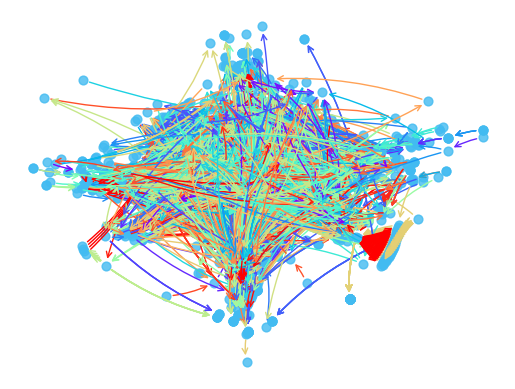

Function selector list:  {'0x', '0x947fe812', '0xe31593d8', '0xec0ab6a7', '0xdedccfb5', '0xbc127b88', '0xca4f2803', '0xc35c83fc', '0xa5dcbcdf', '0x682cba19', '0xad3be54a', '0xdd62ed3e', '0xd216ce6f', '0xe2216330', '0x849ce572', '0xe20463c3', '0xf551e2ee', '0x27dbbf70', '0x03a8ca76', '0x8bddf187', '0x10d1e85c', '0xbecbcc6a', '0x2f40e734', '0xec1bd6c6', '0x00208017', '0x2b6d5d8f', '0x685056ff', '0xd7ff8a80', '0xd0f5941a', '0x0204b27c', '0x28af8d0b', '0xe43833e2', '0xcefa7799', '0x8803dbee', '0xe6fb317f', '0x25d7776b', '0x1716edf1', '0xf740f328', '0x02992be8', '0x6a2b69f0', '0x682cb9e3', '0x9fa45373', '0xddca3f43', '0x6108a29d', '0x08040115', '0x2b6ce7ec', '0x2f52ebb7', '0x07ee40bf', '0x52f55eed', '0x6678f790', '0xee7fc5a3', '0x35269315', '0x0031ad78', '0xc19d93fb', '0x3a3e369a', '0x03eae29c', '0x682cba51', '0x15afd409', '0x64ee4b80', '0xe4fc6b6d', '0x5c60da1b', '0x1ad8b03b', '0x83d13e01', '0x67ca7c91', '0x18c0bf96', '0x876f303b', '0x0b0d9c09', '0xf3d71e41', '0x85919c5d', '0xd54de06f', '0

In [ ]:
component_id = 0

print("The component with the ID {} has {} nodes".format(
    component_id, len(components[component_id])))
g = G.subgraph(components[component_id])
show_graph_info(g)
nx.write_gexf(g, "./components/graph_component_{}.gexf".format(component_id))

draw_multi_graph(g, pos=nx.kamada_kawai_layout(
    g), node_size=40, alpha=0.8, arrowsize=10)
plt.show()

print('Function selector list: ', set(
    map(lambda x: (x[2]['selector']), g.edges(data=True))))

for node_u, node_v, data in sorted(g.edges(data=True), key=lambda x: x[2]['timestamp']):
    function_selector = data['selector']
    print(node_u, '->', node_v, function_selector,
          data['timestamp'], data['value'], data['tx_hash'])

In [40]:
# Use common function selectors:

# 0xa9059cbb: transfer(address,uint256): The caller of the transaction is sending tokens from their own balance to someone else.
# 0x23b872dd: transferFrom(address,address,uint256): The caller is not the owner of the funds but is authorized to move tokens on someone else's behalf.

# Common ERC-20 selectors
TRANSFER_SELECTOR = "0xa9059cbb"
TRANSFER_FROM_SELECTOR = "0x23b872dd"

# Filter relevant calls
token_calls = df.filter(
    pl.col("function_selector").is_in(
        [TRANSFER_SELECTOR, TRANSFER_FROM_SELECTOR])
)

# Decoder function


def decode_transfer_input(input_hex: str):
    if not input_hex.startswith("0x") or len(input_hex) < 138:
        return None, None, None  # Not a valid input

    selector = input_hex[:10]

    try:
        if selector == TRANSFER_SELECTOR:
            # transfer(address to, uint256 amount)
            to_address = "0x" + input_hex[34:74][-40:]
            value = int(input_hex[74:138], 16)
            return None, to_address, value

        elif selector == TRANSFER_FROM_SELECTOR:
            # transferFrom(address from, address to, uint256 amount)
            from_address = "0x" + input_hex[34:74][-40:]
            to_address = "0x" + input_hex[98:138][-40:]
            value = int(input_hex[138:202], 16)
            return from_address, to_address, value

        else:
            return None, None, None  # Unsupported selector
    except Exception:
        return None, None, None  # Safe fallback


decoded_df = token_calls.select([
    "function_selector", "from", 'to', "input", "tx_hash", "value",
]).with_columns([
    pl.col("input").map_elements(lambda x: decode_transfer_input(
        x)[0], return_dtype=pl.String).alias("from_address"),
    pl.col("input").map_elements(lambda x: decode_transfer_input(
        x)[1], return_dtype=pl.String).alias("to_address"),
    pl.col("input").map_elements(lambda x: decode_transfer_input(
        x)[2], return_dtype=pl.Float64).alias("amount"),
])

# decoded = token_calls.select([
#     "from", 'to', "input", "tx_hash"
# ]).with_columns([
#     pl.col("input").map_elements(
#         lambda x: decode_transfer_input(x)[0], return_dtype=pl.String).alias("token_to"),
#     pl.col("input").map_elements(
#         lambda x: decode_transfer_input(x)[1], return_dtype=pl.Float64).alias("token_value")
# ])
decoded_df.collect().head()

function_selector,from,to,input,tx_hash,value,from_address,to_address,amount
str,str,str,str,str,f64,str,str,f64
"""0x23b872dd""","""0x1231deb6f5749ef6ce6943a275a1…","""0x833589fcd6edb6e08f4c7c32d4f7…","""0x23b872dd00000000000000000000…","""0x068fe17b56909063edc72a258e55…",0.0,"""0x242f656b099a188bfc523bd56f84…","""0x1231deb6f5749ef6ce6943a275a1…",1e6
"""0xa9059cbb""","""0x1231deb6f5749ef6ce6943a275a1…","""0xd9aaec86b65d86f6a7b5b1b0c42f…","""0xa9059cbb00000000000000000000…","""0x068fe17b56909063edc72a258e55…",0.0,null,"""0x242f656b099a188bfc523bd56f84…",991784.0
"""0x23b872dd""","""0x833589fcd6edb6e08f4c7c32d4f7…","""0x2ce6311ddae708829bc0784c967b…","""0x23b872dd00000000000000000000…","""0x068fe17b56909063edc72a258e55…",0.0,"""0x242f656b099a188bfc523bd56f84…","""0x1231deb6f5749ef6ce6943a275a1…",1e6
"""0x23b872dd""","""0x0a6d96e7f4d7b96cfe42185df61e…","""0x833589fcd6edb6e08f4c7c32d4f7…","""0x23b872dd00000000000000000000…","""0x068fe17b56909063edc72a258e55…",0.0,"""0x1231deb6f5749ef6ce6943a275a1…","""0x0a6d96e7f4d7b96cfe42185df61e…",7000.0
"""0x23b872dd""","""0x6131b5fae19ea4f9d964eac0408e…","""0x833589fcd6edb6e08f4c7c32d4f7…","""0x23b872dd00000000000000000000…","""0x068fe17b56909063edc72a258e55…",0.0,"""0x1231deb6f5749ef6ce6943a275a1…","""0x6e4141d33021b52c91c28608403d…",993000.0


In [50]:
data = token_calls.filter(pl.col('tx_hash').eq(
    '0x068fe17b56909063edc72a258e55ada673f83790f6cb05cbef839730780c058f'))
for row in data.collect().iter_rows(named=True):
    print(f"tx_index={row['tx_index']}\ttrace_depth={row['trace_depth']}\tfrom={row['from']}, to={row['to']}\tvalue={row['value']}\tfrom_label={row['from_label']}\tto_label={row['to_label']}\tfunction_selector={row['function_selector']}\tcall_type={row['call_type']}")

tx_index=69	trace_depth=2	from=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae, to=0x833589fcd6edb6e08f4c7c32d4f71b54bda02913	value=0.0	from_label=0x1231...4eae	to_label=USDC (USDC)	function_selector=0x23b872dd	call_type=call
tx_index=69	trace_depth=2	from=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae, to=0xd9aaec86b65d86f6a7b5b1b0c42ffa531710b6ca	value=0.0	from_label=0x1231...4eae	to_label=USD Base Coin (USDbC)	function_selector=0xa9059cbb	call_type=call
tx_index=69	trace_depth=3	from=0x833589fcd6edb6e08f4c7c32d4f71b54bda02913, to=0x2ce6311ddae708829bc0784c967b7d77d19fd779	value=0.0	from_label=USDC (USDC)	to_label=Circle	function_selector=0x23b872dd	call_type=delegatecall
tx_index=69	trace_depth=3	from=0x0a6d96e7f4d7b96cfe42185df61e64d255c12dff, to=0x833589fcd6edb6e08f4c7c32d4f71b54bda02913	value=0.0	from_label=0x0a6d...2dff	to_label=USDC (USDC)	function_selector=0x23b872dd	call_type=call
tx_index=69	trace_depth=3	from=0x6131b5fae19ea4f9d964eac0408e4408b66337b5, to=0x833589fcd6edb6e08f4c7c32d

In [54]:
token_calls.filter(pl.col('tx_hash').eq(
    '0x068fe17b56909063edc72a258e55ada673f83790f6cb05cbef839730780c058f')).select(pl.col('function_selector').value_counts()).collect()

function_selector
struct[2]
"{""0x23b872dd"",6}"
"{""0xa9059cbb"",9}"


In [51]:
data = decoded_df.filter(pl.col('tx_hash').eq(
    '0x068fe17b56909063edc72a258e55ada673f83790f6cb05cbef839730780c058f'))
for row in data.collect().iter_rows(named=True):
    print(f"function_selector={row['function_selector']}\tfrom={row['from']}\tto={row['to']}\tfrom_address={row['from_address']}\tto_address={row['to_address']}\tamount={row['amount']}\tvalue={row['value']}")

function_selector=0x23b872dd	from=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae	to=0x833589fcd6edb6e08f4c7c32d4f71b54bda02913	from_address=0x242f656b099a188bfc523bd56f84a6a9472d9174	to_address=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae	amount=1000000.0	value=0.0
function_selector=0xa9059cbb	from=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae	to=0xd9aaec86b65d86f6a7b5b1b0c42ffa531710b6ca	from_address=None	to_address=0x242f656b099a188bfc523bd56f84a6a9472d9174	amount=991784.0	value=0.0
function_selector=0x23b872dd	from=0x833589fcd6edb6e08f4c7c32d4f71b54bda02913	to=0x2ce6311ddae708829bc0784c967b7d77d19fd779	from_address=0x242f656b099a188bfc523bd56f84a6a9472d9174	to_address=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae	amount=1000000.0	value=0.0
function_selector=0x23b872dd	from=0x0a6d96e7f4d7b96cfe42185df61e64d255c12dff	to=0x833589fcd6edb6e08f4c7c32d4f71b54bda02913	from_address=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae	to_address=0x0a6d96e7f4d7b96cfe42185df61e64d255c12dff	amount=7000.0	value=0.0
fu

In [33]:
data = df.filter(pl.col('tx_hash').eq(
    '0x068fe17b56909063edc72a258e55ada673f83790f6cb05cbef839730780c058f'))
for row in data.collect().iter_rows(named=True):
    print(
        f"function_selector={row['function_selector']}, from={row['from']}, to={row['to']}, sub_traces={row['sub_traces']}, trace_depth={row['trace_depth']}")

function_selector=0x5fd9ae2e, from=0x242f656b099a188bfc523bd56f84a6a9472d9174, to=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae, sub_traces=1, trace_depth=0
function_selector=0x5fd9ae2e, from=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae, to=0x31a9b1835864706af10103b31ea2b79bdb995f5f, sub_traces=10, trace_depth=1
function_selector=0x70a08231, from=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae, to=0x833589fcd6edb6e08f4c7c32d4f71b54bda02913, sub_traces=1, trace_depth=2
function_selector=0x23b872dd, from=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae, to=0x833589fcd6edb6e08f4c7c32d4f71b54bda02913, sub_traces=1, trace_depth=2
function_selector=0xdd62ed3e, from=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae, to=0x833589fcd6edb6e08f4c7c32d4f71b54bda02913, sub_traces=1, trace_depth=2
function_selector=0x70a08231, from=0x1231deb6f5749ef6ce6943a275a1d3e7486f4eae, to=0x833589fcd6edb6e08f4c7c32d4f71b54bda02913, sub_traces=1, trace_depth=2
function_selector=0xeedd56e1, from=0x1231deb6f5749ef6ce6943a275a1d3e7486f4e

In [34]:
# Some bots are calling Uniswap more often, then it would be good to show the connectivity of these bots? Normal trader vs Bots. Can we show the graph network differences for both bots and normal traders?
# Heuristics to detect bots? Can we come up with our own? How they compare with existing heuristics (e.g., Flashbots).
# Make a list of possible heuristics we could test in our graph network analysis.

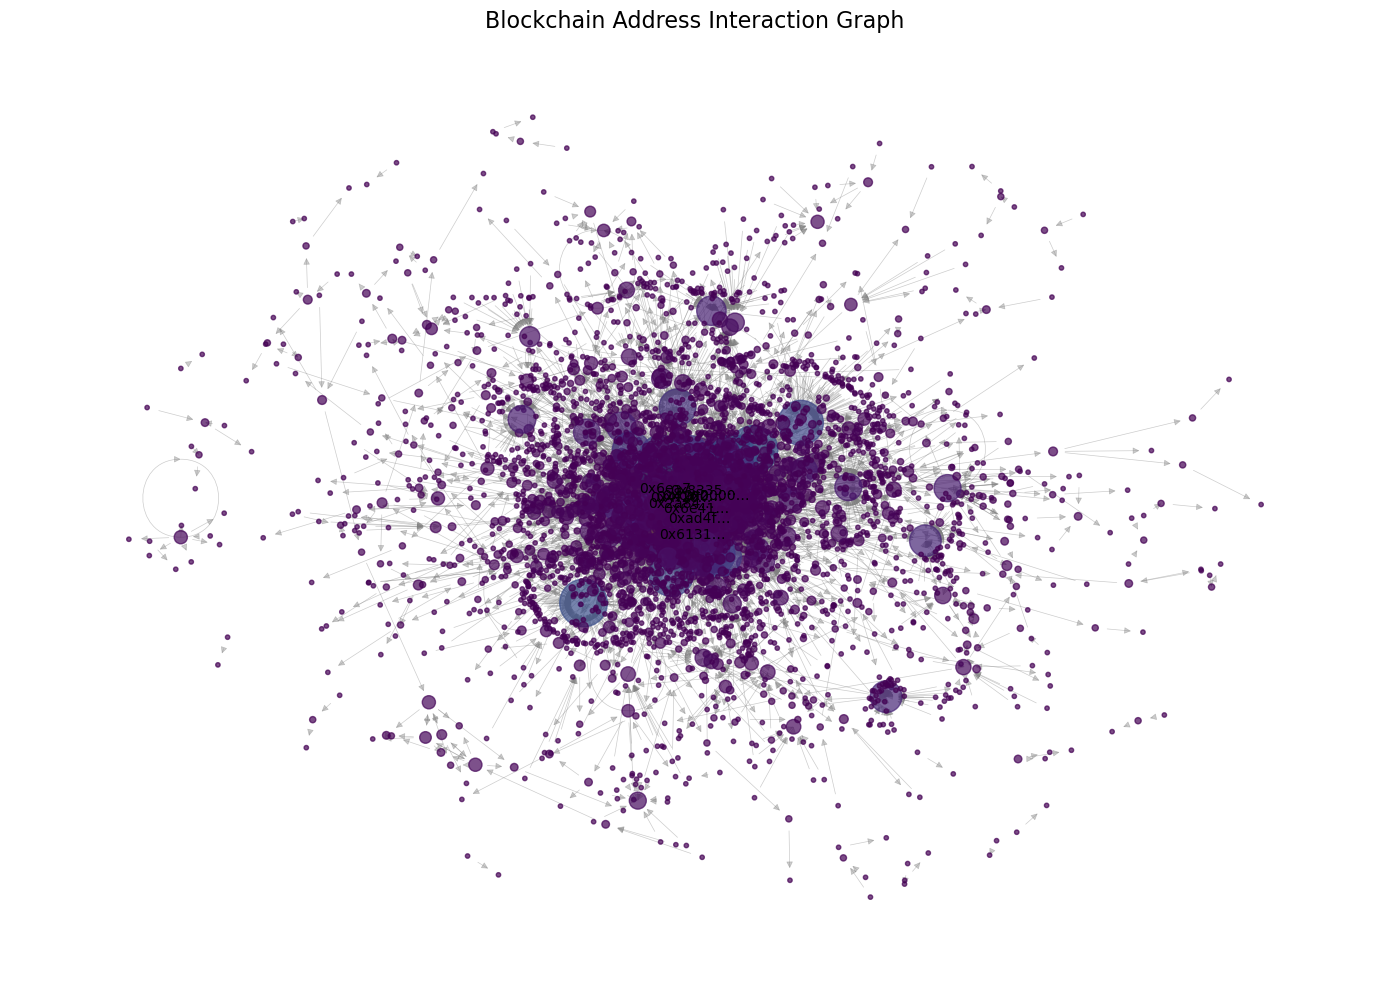

In [35]:
import matplotlib.pyplot as plt
import networkx as nx

# Use spring layout (force-directed, aesthetically pleasing)
pos = nx.spring_layout(G, seed=42, k=0.3)  # tweak k for spacing

# Node degrees for size and color
degrees = dict(G.degree())
node_sizes = [degrees[n] * 10 for n in G.nodes()]
node_colors = [degrees[n] for n in G.nodes()]

# Draw nodes
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.7
)

# Draw edges
nx.draw_networkx_edges(
    G, pos,
    edge_color='gray',
    width=0.5,
    alpha=0.4,
    arrows=True
)

# Optionally draw labels (e.g., top nodes only)
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_node_labels = {n: n[:6] + "…" for n, _ in top_nodes}

nx.draw_networkx_labels(
    G, pos,
    labels=top_node_labels,
    font_size=10,
    font_color="black"
)

plt.title("Blockchain Address Interaction Graph", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

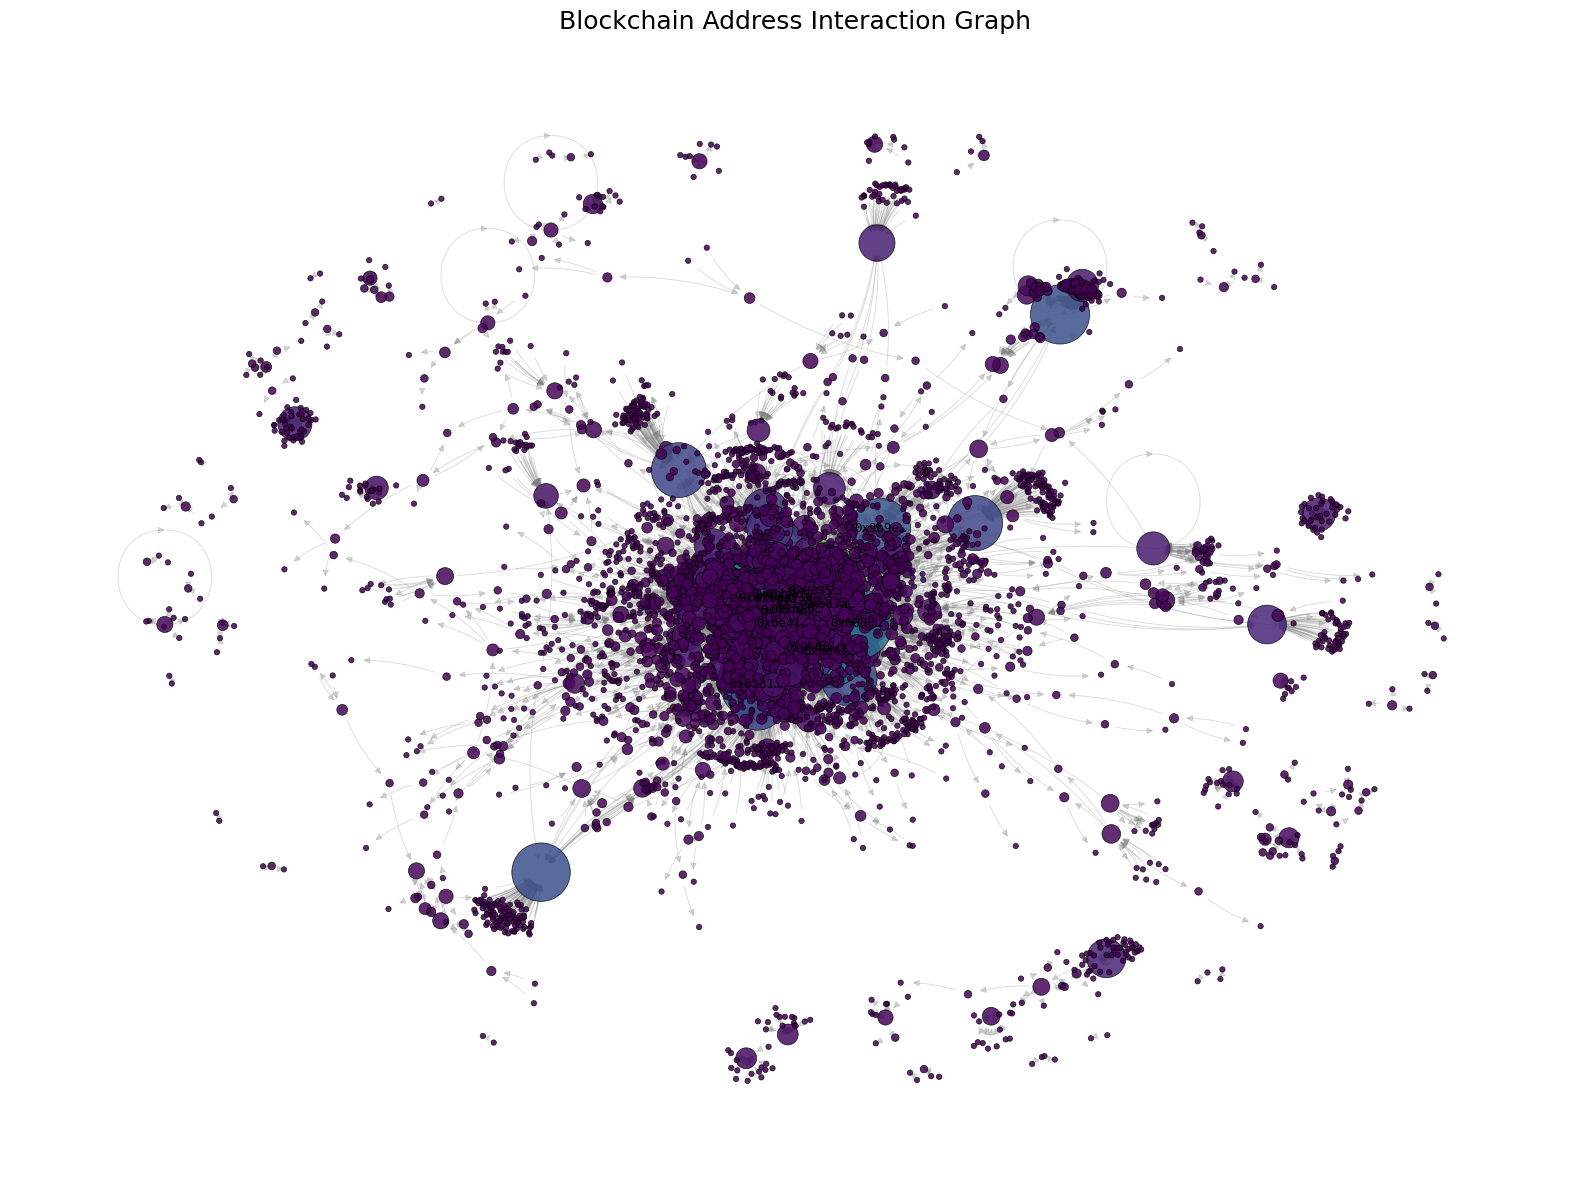

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

# Force-directed layout with improved spacing
pos = nx.spring_layout(G, seed=42, k=0.4, iterations=100)

# Degree-based sizing and coloring
degrees = dict(G.degree())
max_degree = max(degrees.values()) if degrees else 1

node_sizes = [degrees[n] * 15 for n in G.nodes()]
node_colors = [degrees[n] for n in G.nodes()]

# Normalize colors
norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))

plt.figure(figsize=(16, 12))

# Draw edges with curvature and transparency
nx.draw_networkx_edges(
    G, pos,
    edge_color='gray',
    width=0.6,
    alpha=0.3,
    connectionstyle='arc3,rad=0.1'  # curved edges
)

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.85,
    linewidths=0.5,
    edgecolors='black'
)

# Colorbar for node degree
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
# cbar = plt.colorbar(sm, shrink=0.6)
# cbar.set_label('Node Degree', fontsize=12)

# Show only top 15 nodes by degree
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:15]
top_node_labels = {n: n[:6] + "…" for n, _ in top_nodes}

nx.draw_networkx_labels(
    G, pos,
    labels=top_node_labels,
    font_size=9,
    font_color="black",
    font_family="monospace"
)

plt.title("Blockchain Address Interaction Graph", fontsize=18)
plt.axis("off")
plt.tight_layout()
plt.show()

In [37]:
# import networkx as nx
# import plotly.graph_objects as go

# # Example: Use your actual graph G
# # pos = nx.spring_layout(G, seed=42)  # force-directed layout
# pos = nx.kamada_kawai_layout(G)  # often prettier for smaller graphs

# # Extract edge coordinates
# edge_x = []
# edge_y = []
# for u, v in G.edges():
#     x0, y0 = pos[u]
#     x1, y1 = pos[v]
#     edge_x.extend([x0, x1, None])
#     edge_y.extend([y0, y1, None])

# edge_trace = go.Scatter(
#     x=edge_x, y=edge_y,
#     line=dict(width=0.5, color='#888'),
#     hoverinfo='none',
#     mode='lines'
# )

# # Extract node positions and hover info
# node_x = []
# node_y = []
# node_text = []
# node_size = []

# for node in G.nodes():
#     x, y = pos[node]
#     node_x.append(x)
#     node_y.append(y)

#     # Customize hover text
#     degree = G.degree[node]
#     node_text.append(f"Address: {node}<br>Degree: {degree}")

#     # Optional: scale node size
#     node_size.append(degree * 3 + 10)

# node_trace = go.Scatter(
#     x=node_x, y=node_y,
#     mode='markers',
#     hoverinfo='text',
#     text=node_text,
#     marker=dict(
#         showscale=True,
#         colorscale='Viridis',
#         color=[G.degree(n) for n in G.nodes()],
#         size=node_size,
#         colorbar=dict(
#             thickness=15,
#             title='Node Degree',
#             xanchor='left',
#             titleside='right'
#         ),
#         line_width=2
#     )
# )

# # Build the figure
# fig = go.Figure(
#     data=[edge_trace, node_trace],
#     layout=go.Layout(
#         title='Blockchain Address Interaction Graph',
#         titlefont_size=16,
#         showlegend=False,
#         hovermode='closest',
#         margin=dict(b=20, l=5, r=5, t=40),
#         annotations=[dict(
#             text="Use scroll or drag to explore the network.",
#             showarrow=False,
#             xref="paper", yref="paper",
#             x=0.005, y=-0.002
#         )],
#         xaxis=dict(showgrid=False, zeroline=False),
#         yaxis=dict(showgrid=False, zeroline=False)
#     )
# )

# fig.show()

In [38]:
# from pyvis.network import Network

# net = Network(height="10000px", width="10000px", notebook=True)
# net.from_nx(G)
# net.show("nx.html")

In [39]:
# from pyvis.network import Network
# import networkx as nx
# nx_graph = nx.cycle_graph(10)
# nx_graph.nodes[1]['title'] = 'Number 1'
# nx_graph.nodes[1]['group'] = 1
# nx_graph.nodes[3]['title'] = 'I belong to a different group!'
# nx_graph.nodes[3]['group'] = 10
# nx_graph.add_node(20, size=20, title='couple', group=2)
# nx_graph.add_node(21, size=15, title='couple', group=2)
# nx_graph.add_edge(20, 21, weight=5)
# nx_graph.add_node(25, size=25, label='lonely', title='lonely node', group=3)
# nt = Network('500px', '500px', notebook=True)
# # populates the nodes and edges data structures
# nt.from_nx(nx_graph)
# nt.show('nx.html')